# Experimenting with narrowband filtering of signals

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, welch
from scipy.interpolate import PchipInterpolator
import pywt
from numpy import trapezoid as _trapz
from scipy.signal import hilbert
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

In [54]:
def bandpass(x, Fs, lo=3.0, hi=7.0, order=8):
    nyq = 0.5 * Fs
    sos = butter(order, [lo / nyq, hi / nyq], btype='bandpass', output='sos')
    return sosfiltfilt(sos, x)

def plot_bandpass_effect(x, Fs, bands, order=8, title=None):
    """
    Apply bandpass filters (1 or 2) and plot original, filtered, and their power spectra.

    Parameters:
        x : np.array
            Input signal.
        Fs : float
            Sampling frequency (Hz).
        bands : list of (lo, hi) tuples
            One or two frequency bands to apply.
        order : int
            Filter order.
        title : str
            Optional base title.
    """
    t = np.arange(len(x)) / Fs
    n_bands = len(bands)

    # Filter the signal for each band
    filtered_signals = []
    for lo, hi in bands:
        filtered = bandpass(x, Fs, lo, hi, order)
        filtered_signals.append(filtered)

    # Color cycle for filtered traces
    colors = ['tab:blue', 'tab:orange', 'pink']

    # Create figure
    fig, axs = plt.subplots(n_bands + 2, 1, figsize=(10, 2.5 * (n_bands + 2)))

    # Plot original signal
    axs[0].plot(t, x, color='gray')
    axs[0].set_ylabel("Amplitude")
    axs[0].set_title(title or "Original Signal")

    # Plot each filtered signal
    for i, (filt, (lo, hi)) in enumerate(zip(filtered_signals, bands)):
        axs[i + 1].plot(t, filt, color=colors[i])
        axs[i + 1].set_ylabel("Amplitude")
        axs[i + 1].set_title(f"Bandpass {lo}–{hi} Hz (order {order})")

    # Compute and plot power spectra
    freqs = fftfreq(len(t), d=1 / Fs)
    axs[-1].set_xlim(0, 65)
    axs[-1].set_xlabel("Frequency (Hz)")
    axs[-1].set_ylabel("Power (a.u.)")
    axs[-1].set_title("Power Spectrum of Filtered Signal(s)")

    for i, filt in enumerate(filtered_signals):
        fft_vals = fft(filt)
        power = np.abs(fft_vals)**2
        axs[-1].plot(freqs[:len(freqs)//2], power[:len(power)//2], label=f'{bands[i][0]}–{bands[i][1]} Hz', color=colors[i])

    axs[-1].legend()
    plt.tight_layout()
    plt.show()

def plot_modulation_decomposition(signal, Fs, lf_band, hf_band, title=None, order=8):
    """
    Analyze a modulated signal by plotting:
    1. Original signal
    2. Low-frequency bandpassed signal
    3. High-frequency bandpassed signal
    4. Hilbert envelope of HF signal
    5. Power spectra of all components

    Parameters:
        signal : 1D array
        Fs : float
            Sampling frequency (Hz)
        lf_band : tuple (lo, hi)
        hf_band : tuple (lo, hi)
        title : str or None
        order : int
            Butterworth filter order
    """
    t = np.arange(len(signal)) / Fs

    # Filter and extract envelope
    lf_filtered = bandpass(signal, Fs, *lf_band, order=order)
    hf_filtered = bandpass(signal, Fs, *hf_band, order=order)
    envelope = np.abs(hilbert(hf_filtered))

    # Compute FFT-based power spectra
    freqs = fftfreq(len(signal), 1 / Fs)
    pos_mask = freqs >= 1
    freqs = freqs[pos_mask]

    def power(x):
        return np.abs(fft(x))**2

    raw_power = power(signal)[pos_mask]
    lf_power = power(lf_filtered)[pos_mask]
    hf_power = power(hf_filtered)[pos_mask]
    env_power = power(envelope)[pos_mask]

    # Plot
    fig, axs = plt.subplots(5, 1, figsize=(10, 13), gridspec_kw={'height_ratios': [1, 1, 1, 1, 1.2]})

    # Time-domain plots (shared x-axis)
    axs[0].plot(t, signal, color='black')
    axs[0].set_title(title or "Original Modulated Signal")
    axs[0].set_ylabel("Amplitude")

    axs[1].plot(t, lf_filtered, color='blue')
    axs[1].set_title(f"Low-Frequency Bandpass ({lf_band[0]}–{lf_band[1]} Hz)")
    axs[1].set_ylabel("Amplitude")

    axs[2].plot(t, hf_filtered, color='orange')
    axs[2].set_title(f"High-Frequency Bandpass ({hf_band[0]}–{hf_band[1]} Hz)")
    axs[2].set_ylabel("Amplitude")

    axs[3].plot(t, signal, color='black', alpha=0.4, label="Raw Signal")
    axs[3].plot(t, envelope, color='green', label="Envelope (Hilbert Amplitude)")
    axs[3].set_title("Envelope")
    axs[3].set_xlabel("Time (s)")
    axs[3].legend()

    # Power spectrum (separate axis)
    axs[4].plot(freqs, raw_power, color='gray', alpha=0.3, label='Raw Signal')
    axs[4].plot(freqs, lf_power, color='blue', label='LF Bandpassed')
    axs[4].plot(freqs, hf_power, color='orange', label='HF Bandpassed')
    axs[4].plot(freqs, env_power, color='green', label='Envelope')
    axs[4].set_xlim(1, 70)
    axs[4].set_xlabel("Frequency (Hz)")
    axs[4].set_ylabel("Power (a.u.)")
    axs[4].set_title("Power Spectrum")
    axs[4].legend()

    plt.tight_layout()
    plt.show()

## Additive signals (low freq + high freq)

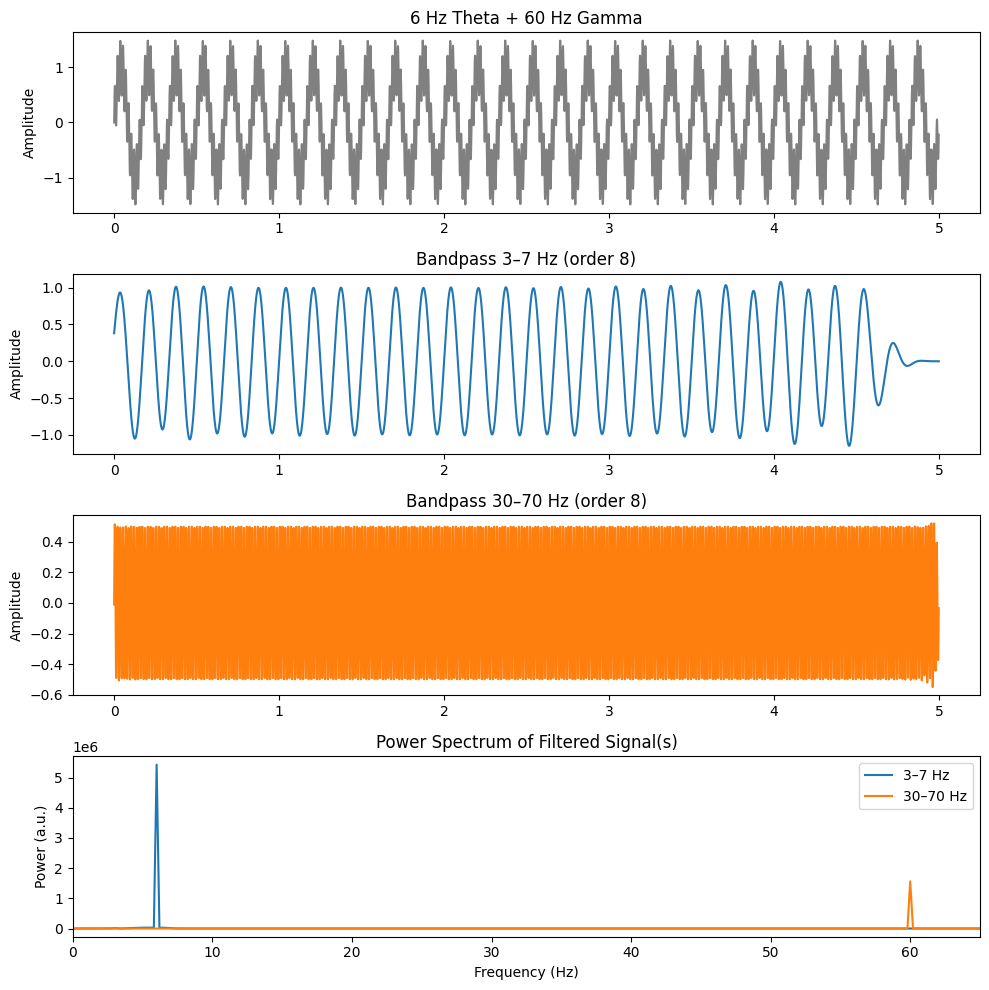

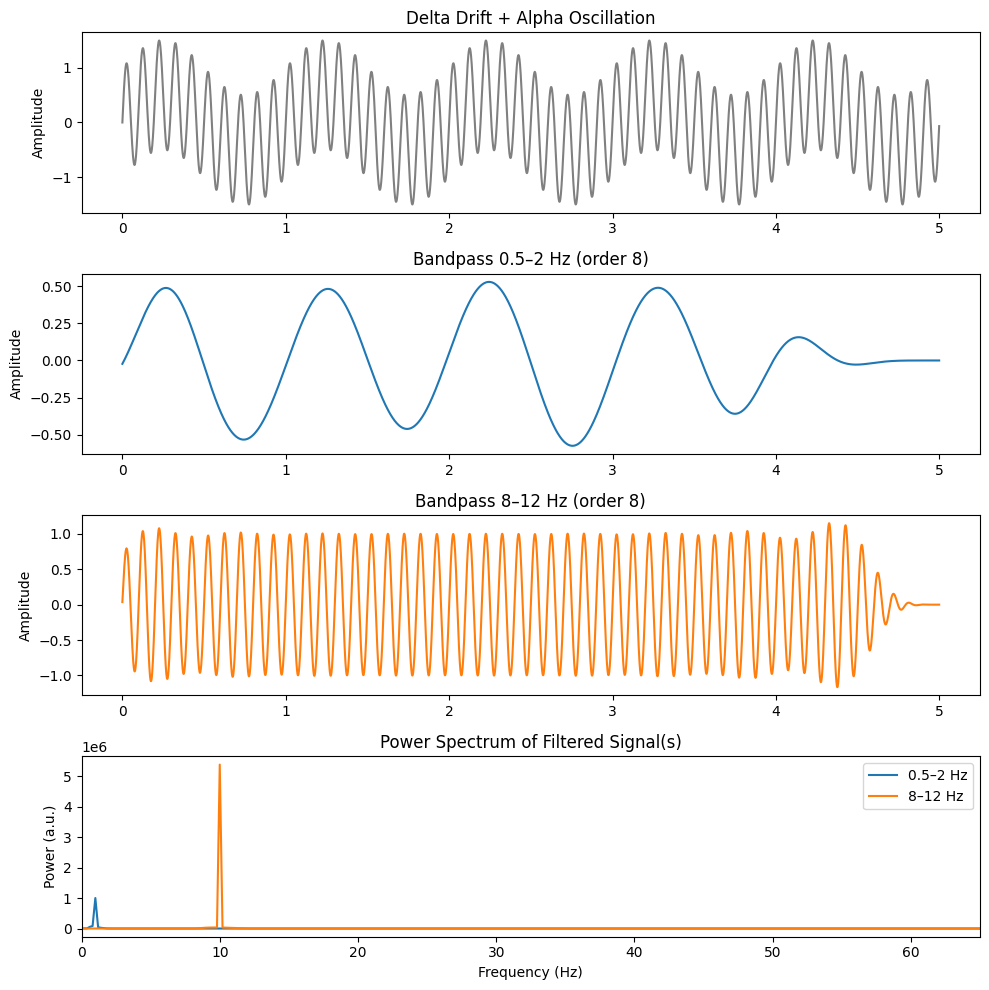

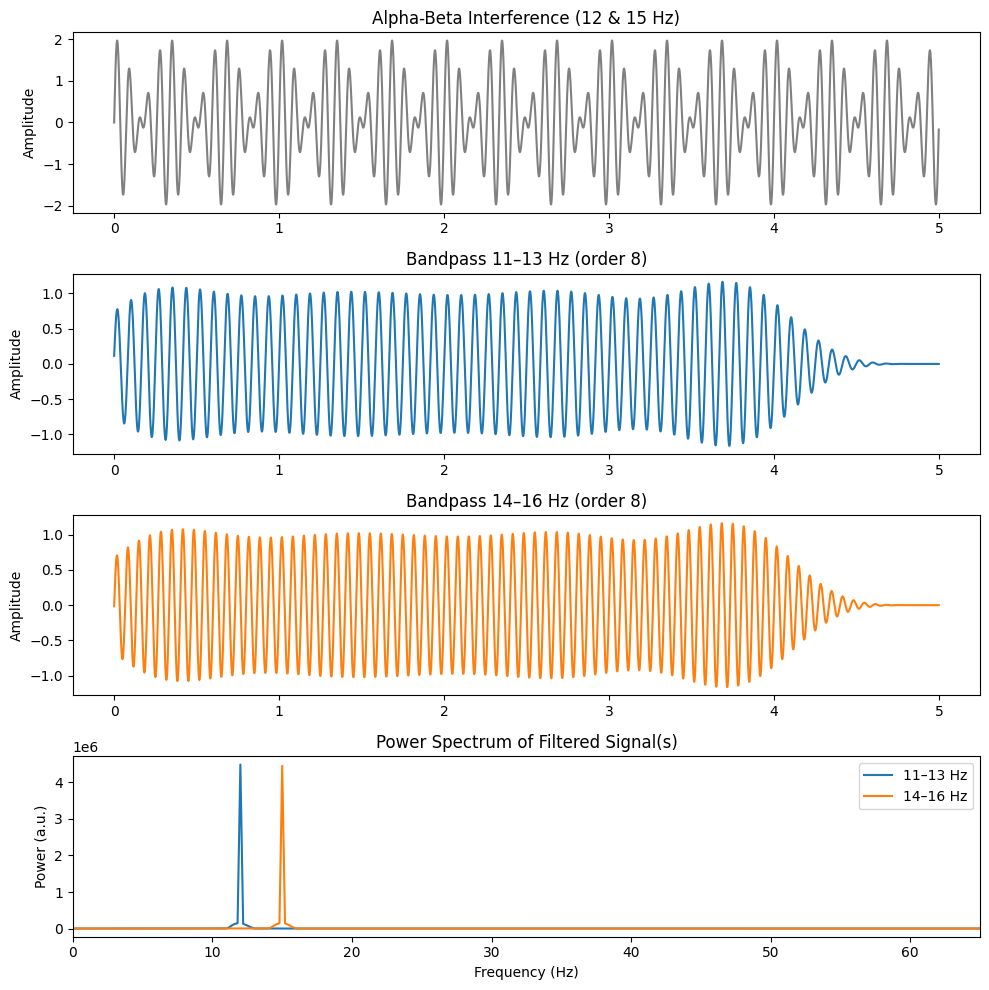

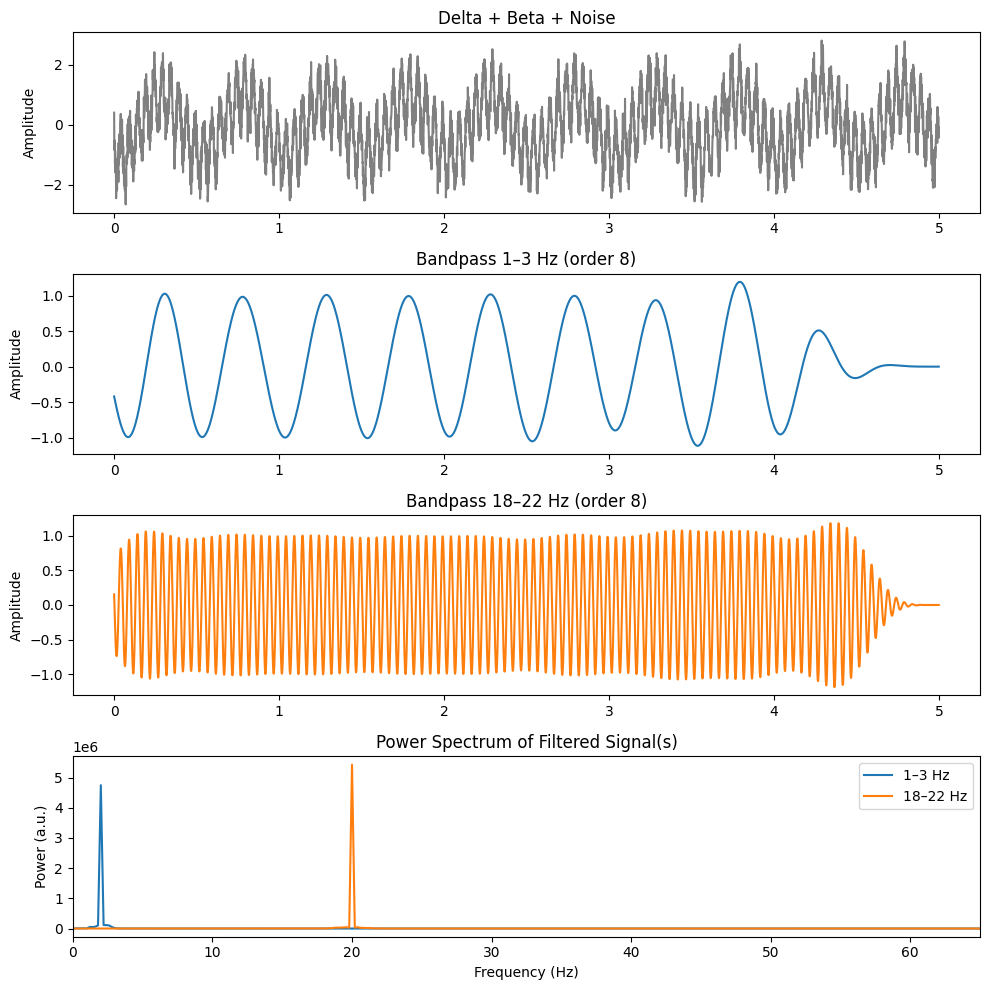

In [55]:
# Sampling settings
Fs = 1000  # Hz
duration = 5.0  # seconds
t = np.arange(0, duration, 1 / Fs)

# Theta (6 Hz) + Gamma (60 Hz)
signal2 = np.sin(2 * np.pi * 6 * t) + 0.5 * np.sin(2 * np.pi * 60 * t)
plot_bandpass_effect(signal2, Fs, bands=[(3, 7), (30, 70)], title='6 Hz Theta + 60 Hz Gamma')

# Slow drift (delta) + alpha (10 Hz) oscillation
signal7 = 0.5 * np.sin(2 * np.pi * 1 * t) + np.sin(2 * np.pi * 10 * t)
plot_bandpass_effect(signal7, Fs, bands=[(0.5, 2), (8, 12)], title='Delta Drift + Alpha Oscillation')

# Beat pattern: interference between 12 Hz and 15 Hz tones
signal9 = np.sin(2 * np.pi * 12 * t) + np.sin(2 * np.pi * 15 * t)
plot_bandpass_effect(signal9, Fs, bands=[(11, 13), (14, 16)], title='Alpha-Beta Interference (12 & 15 Hz)')

# 10. Embedded delta + beta, with random phase and noise
delta = np.sin(2 * np.pi * 2 * t + np.random.rand() * 2 * np.pi)
beta = np.sin(2 * np.pi * 20 * t + np.random.rand() * 2 * np.pi)
noise = 0.3 * np.random.randn(len(t))
signal10 = delta + beta + noise
plot_bandpass_effect(signal10, Fs, bands=[(1, 3), (18, 22)], title='Delta + Beta + Noise')

## Transients, non-constant frequency and other

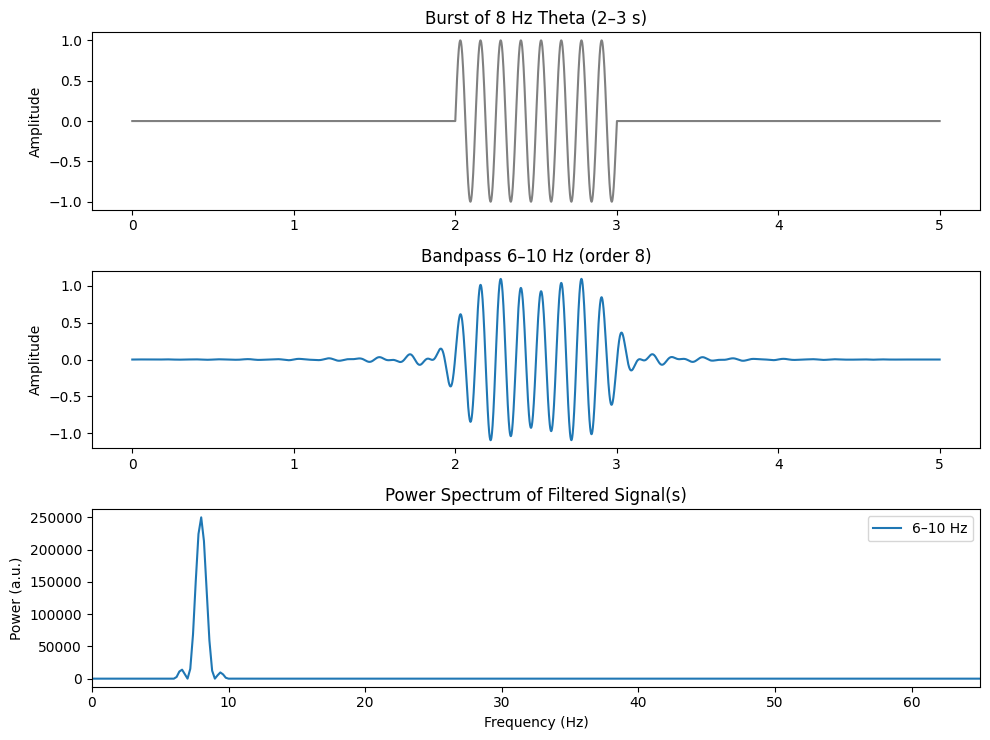

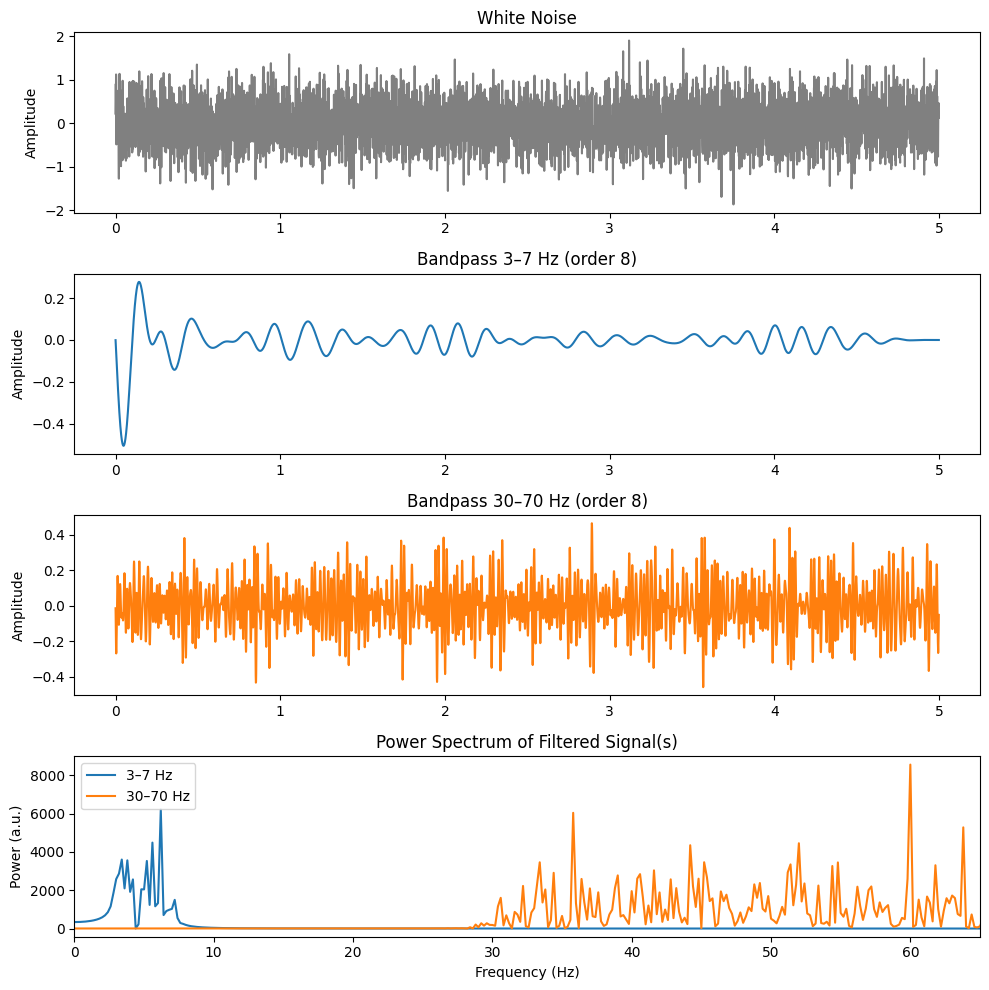

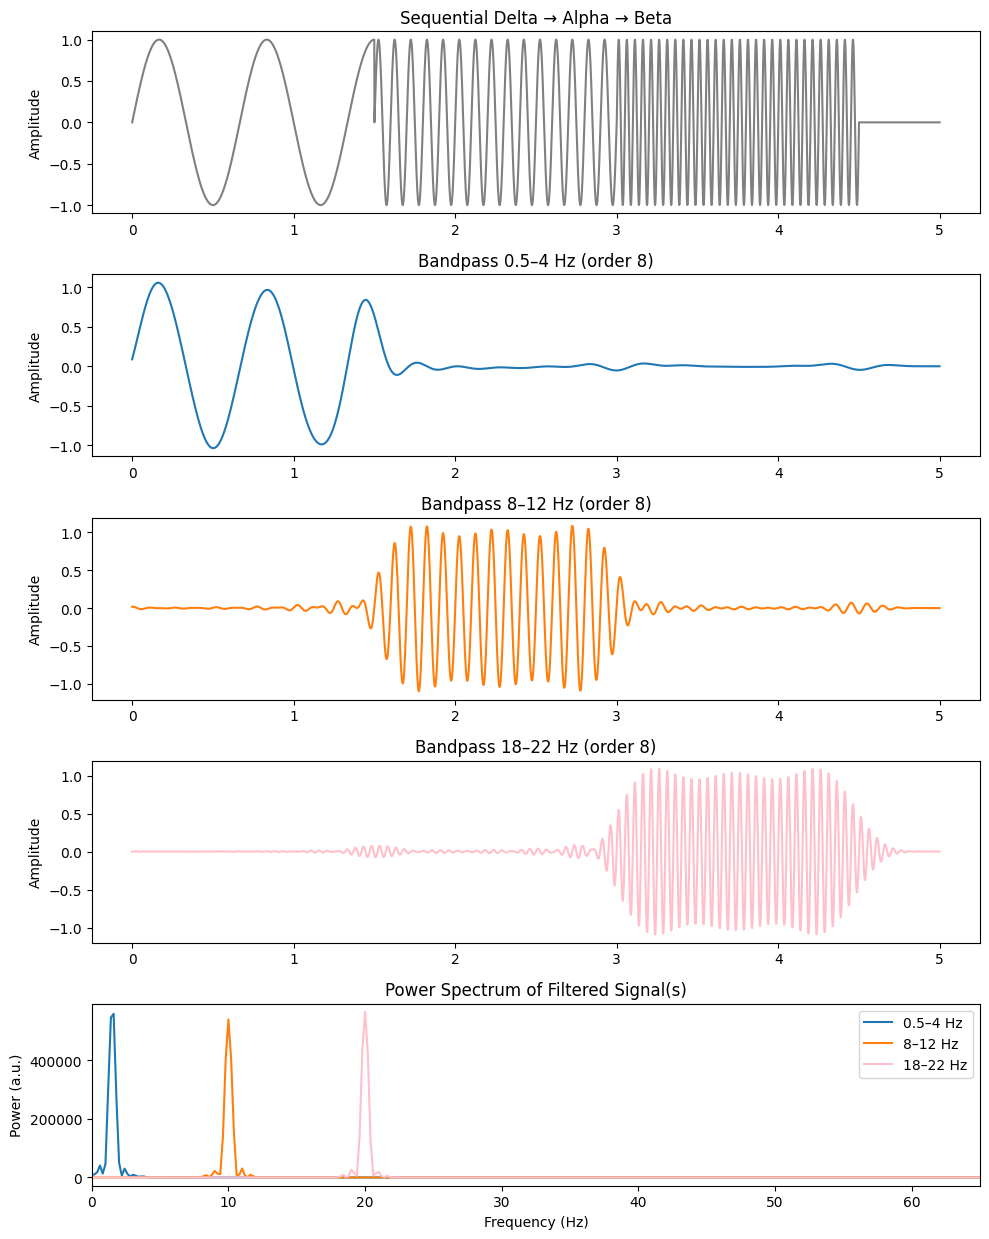

In [56]:
# Burst of 8 Hz theta in the middle of signal
signal5 = np.zeros_like(t)
burst_region = (t > 2) & (t < 3)
signal5[burst_region] = np.sin(2 * np.pi * 8 * t[burst_region])
plot_bandpass_effect(signal5, Fs, bands=[(6, 10)], title='Burst of 8 Hz Theta (2–3 s)')

# White noise (broadband)
np.random.seed(0)
signal3 = np.random.randn(len(t)) * 0.5
plot_bandpass_effect(signal3, Fs, bands=[(3, 7), (30, 70)], title='White Noise')

# Bursts of mixed frequencies: delta, alpha, beta in sequence
signal12 = np.zeros_like(t)
signal12[(t >= 0) & (t < 1.5)] = np.sin(2 * np.pi * 1.5 * t[(t >= 0) & (t < 1.5)])  # delta
signal12[(t >= 1.5) & (t < 3)] = np.sin(2 * np.pi * 10 * t[(t >= 1.5) & (t < 3)])   # alpha
signal12[(t >= 3) & (t < 4.5)] = np.sin(2 * np.pi * 20 * t[(t >= 3) & (t < 4.5)])   # beta
plot_bandpass_effect(signal12, Fs, bands=[(0.5, 4), (8, 12), (18, 22)], title='Sequential Delta → Alpha → Beta')

## Modulatory Signals (low freq * high freq)

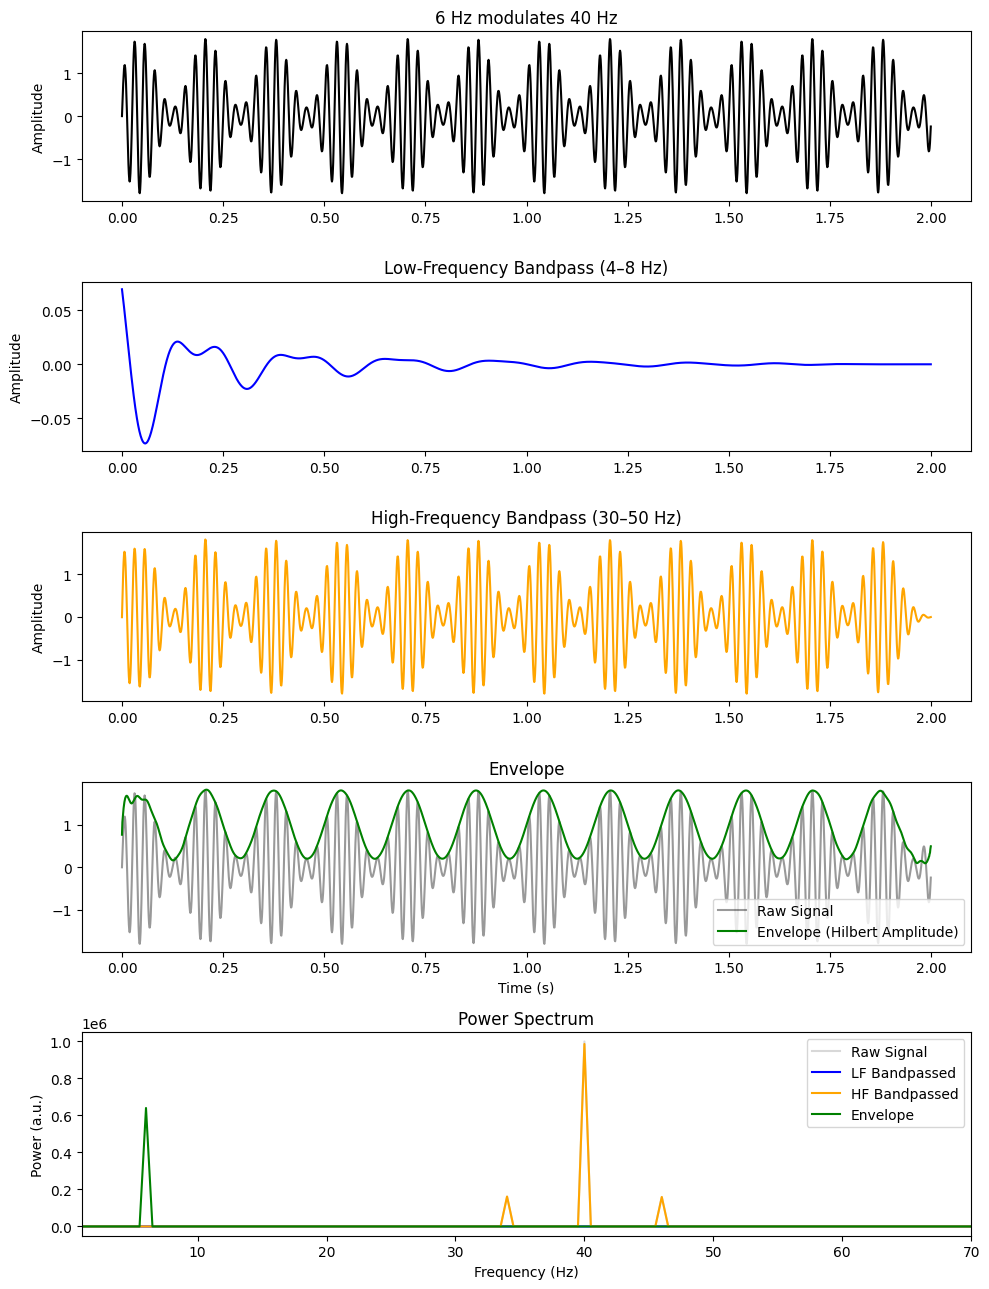

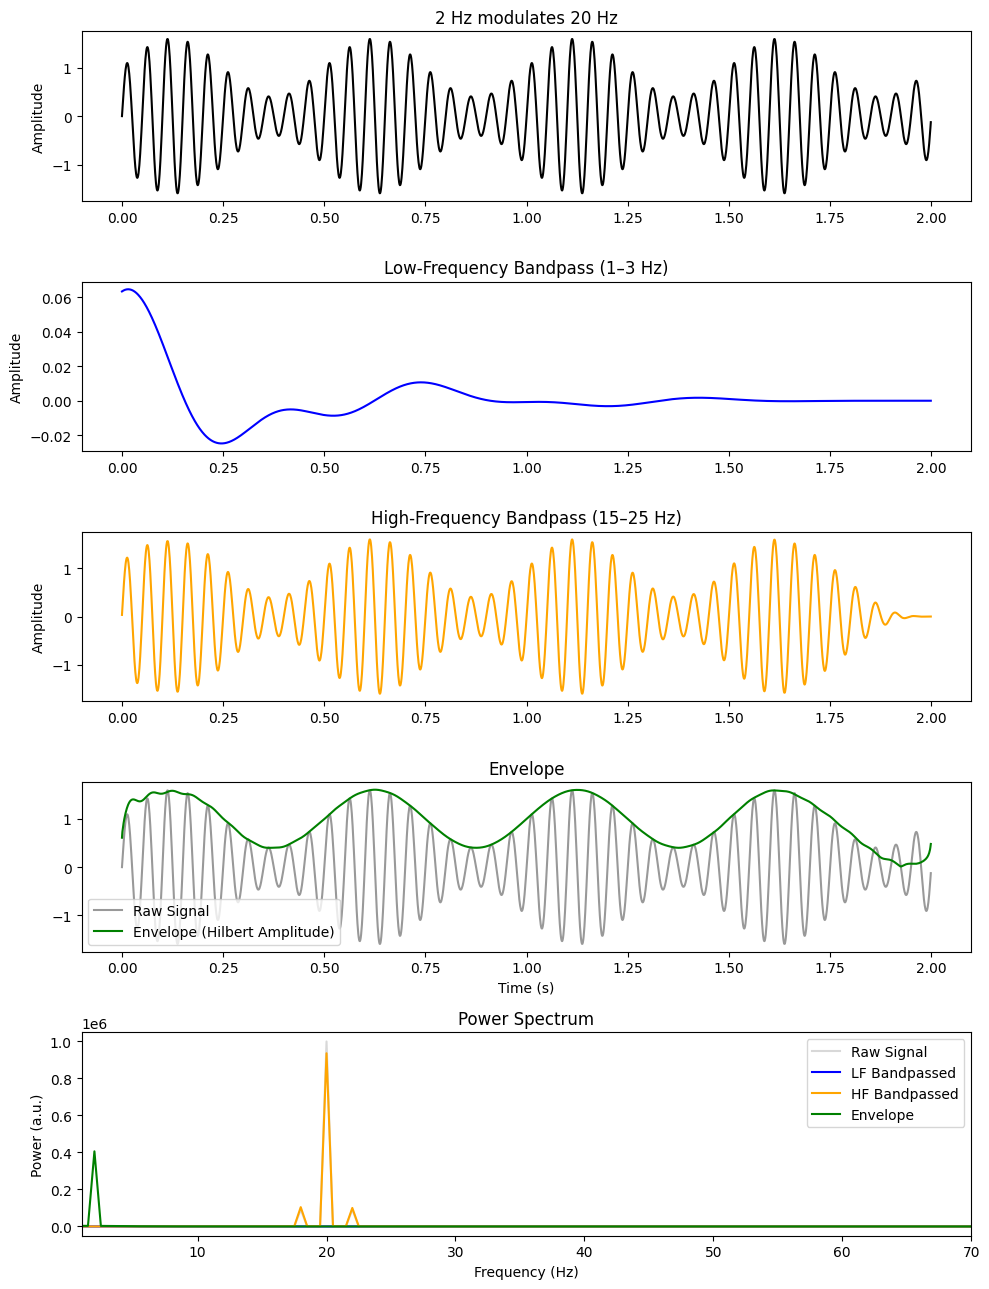

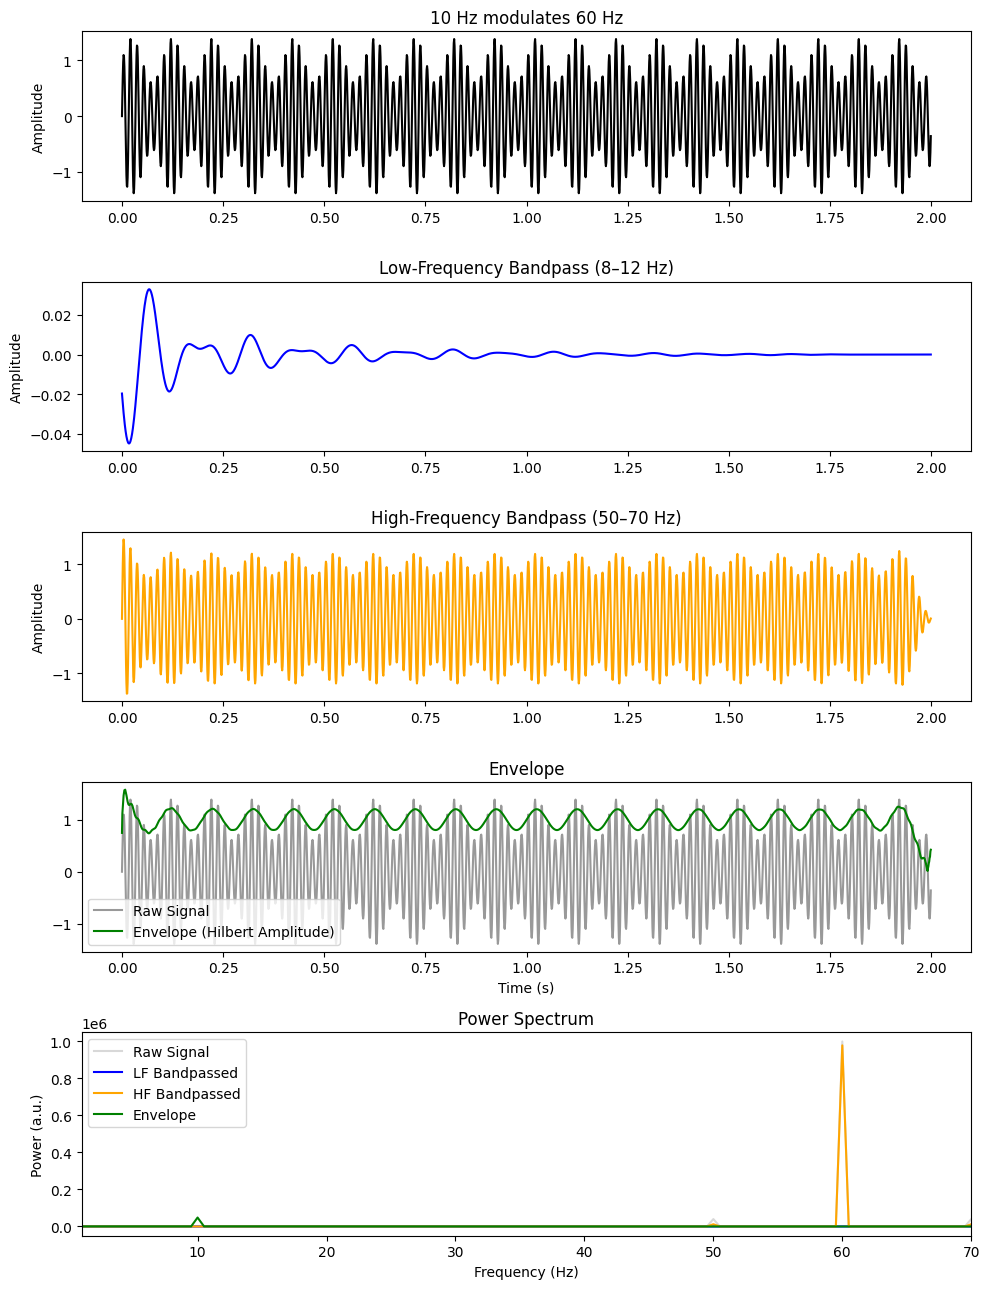

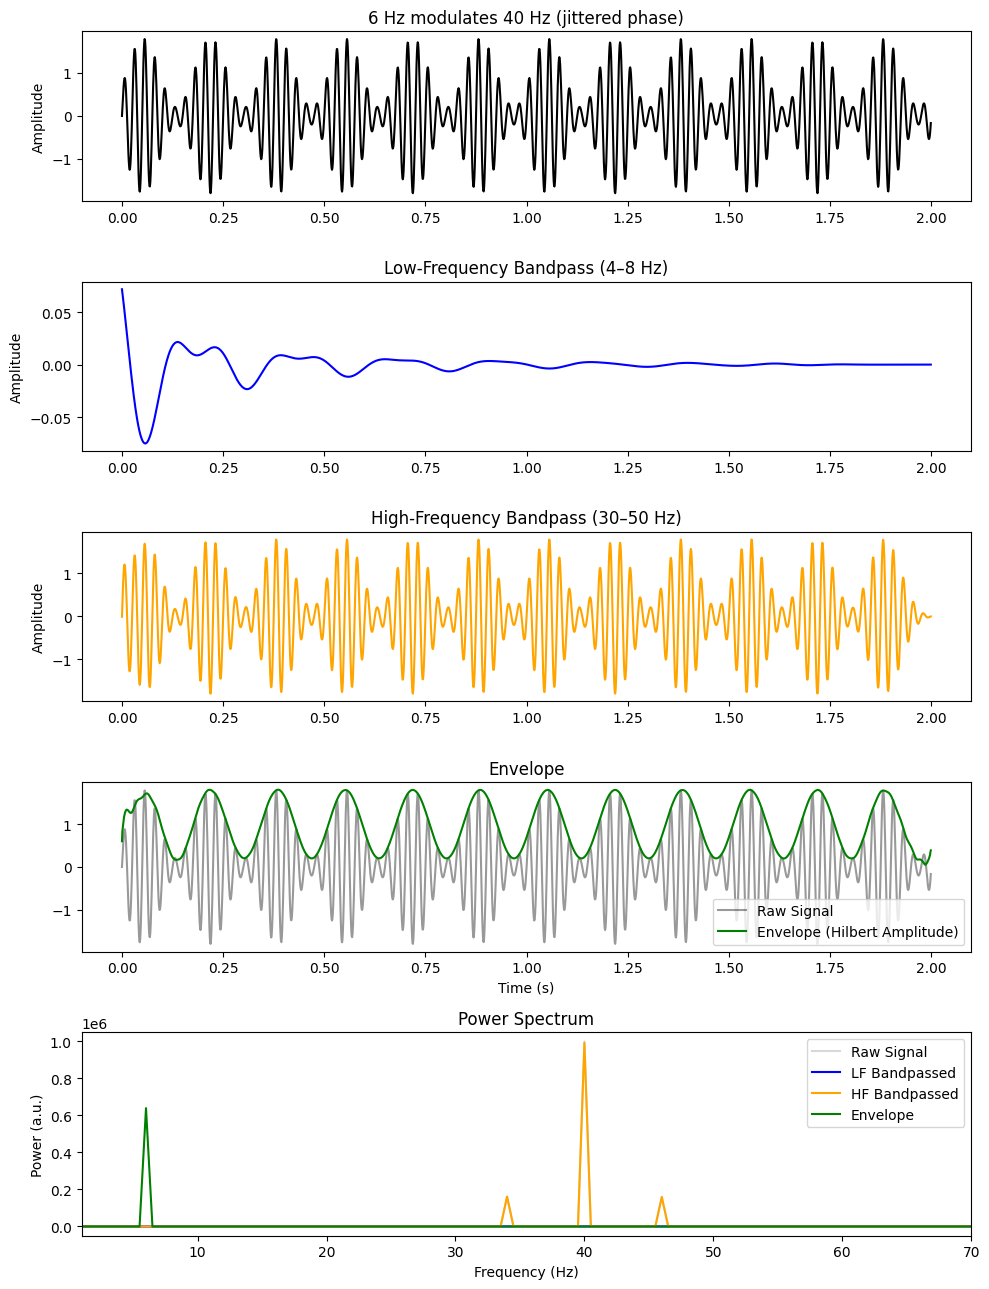

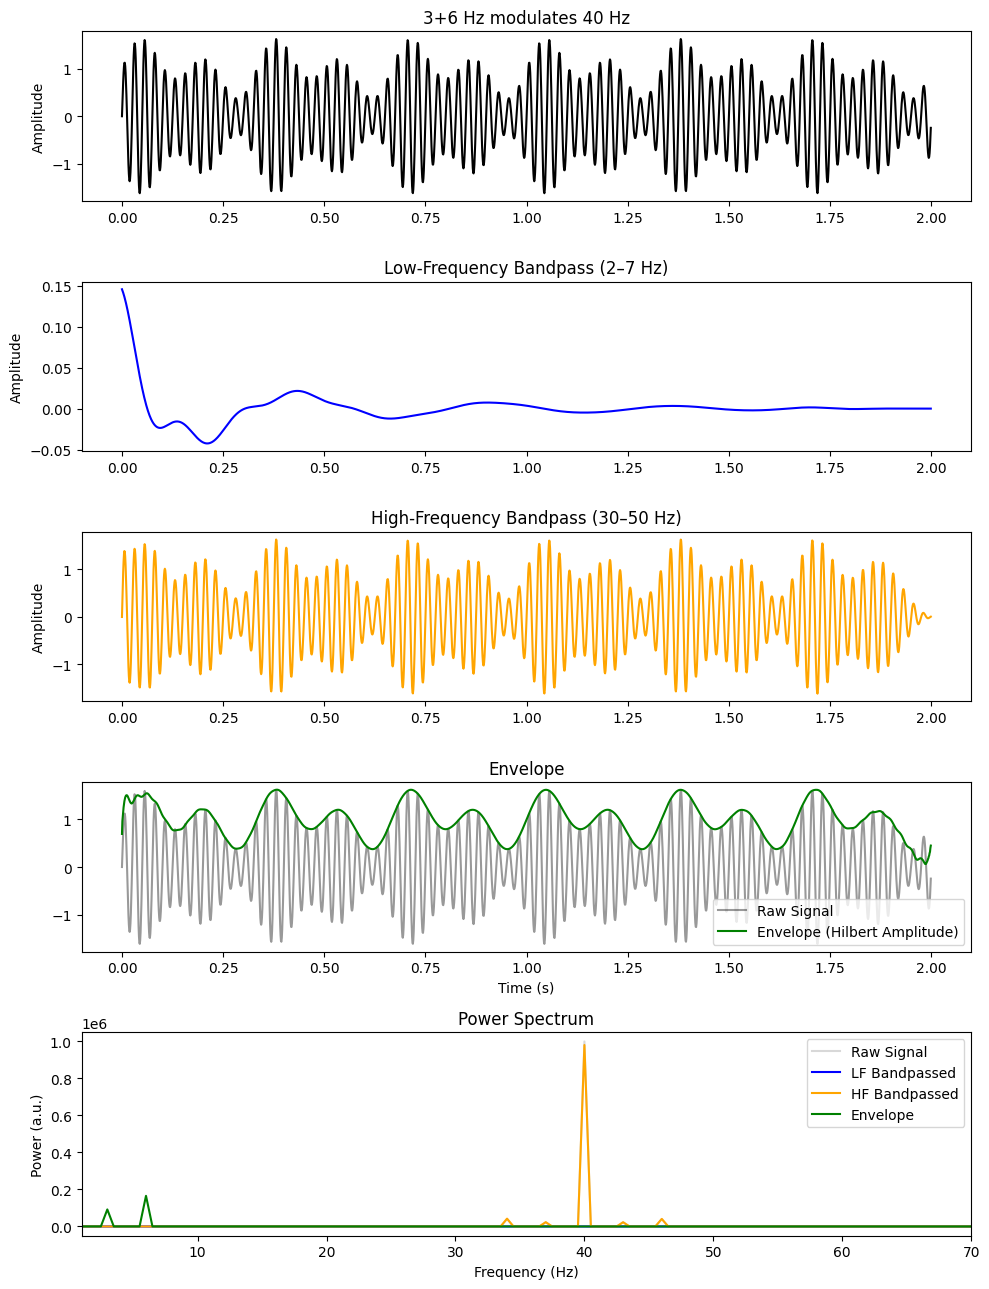

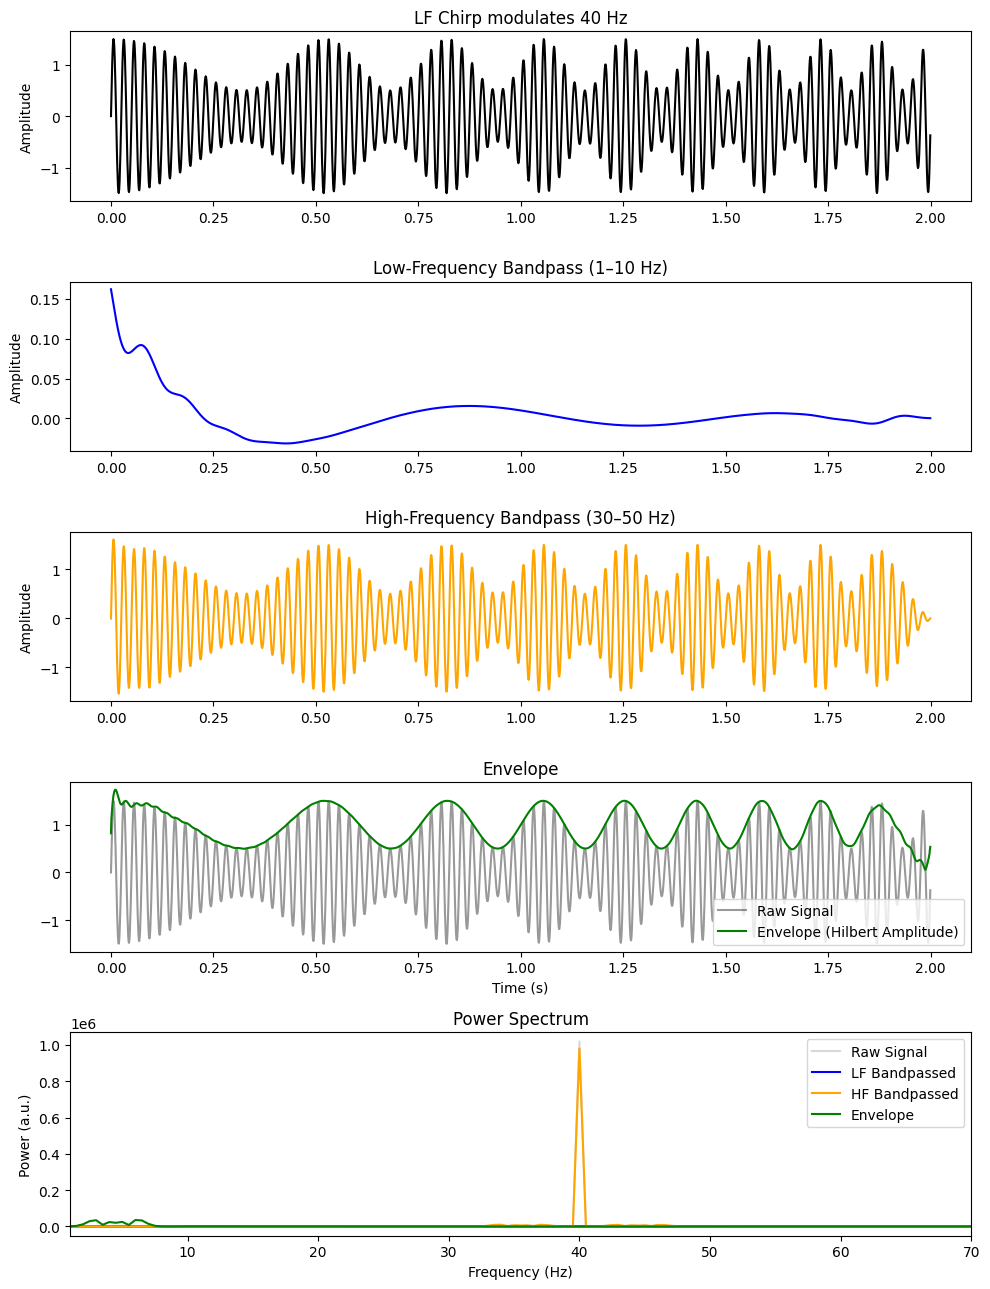

In [57]:
# Time vector
Fs = 1000  # Hz
t = np.arange(0, 2, 1/Fs)  # 2 seconds

# 6 Hz modulates 40 Hz
modulator1 = 1 + 0.8 * np.sin(2 * np.pi * 6 * t)
carrier1 = np.sin(2 * np.pi * 40 * t)
signal1 = modulator1 * carrier1
plot_modulation_decomposition(signal1, Fs, lf_band=(4, 8), hf_band=(30, 50), title="6 Hz modulates 40 Hz")

# 2 Hz modulates 20 Hz (Delta × Beta)
modulator2 = 1 + 0.6 * np.sin(2 * np.pi * 2 * t)
carrier2 = np.sin(2 * np.pi * 20 * t)
signal2 = modulator2 * carrier2
plot_modulation_decomposition(signal2, Fs, lf_band=(1, 3), hf_band=(15, 25), title="2 Hz modulates 20 Hz")

# 10 Hz modulates 60 Hz (Alpha × High Gamma)
modulator3 = 1 + 0.4 * np.sin(2 * np.pi * 10 * t)
carrier3 = np.sin(2 * np.pi * 60 * t)
signal3 = modulator3 * carrier3
plot_modulation_decomposition(signal3, Fs, lf_band=(8, 12), hf_band=(50, 70), title="10 Hz modulates 60 Hz")

# 6 Hz modulates 40 Hz, but with random jitter on phase
modulator6 = 1 + 0.8 * np.sin(2 * np.pi * 6 * t + np.random.uniform(-0.5, 0.5))
carrier6 = np.sin(2 * np.pi * 40 * t)
signal6 = modulator6 * carrier6
plot_modulation_decomposition(signal6, Fs, lf_band=(4, 8), hf_band=(30, 50), title="6 Hz modulates 40 Hz (jittered phase)")

# Mixed modulator (3 Hz + 6 Hz) modulates 40 Hz
modulator7 = 1 + 0.4 * np.sin(2 * np.pi * 6 * t) + 0.3 * np.sin(2 * np.pi * 3 * t)
carrier7 = np.sin(2 * np.pi * 40 * t)
signal7 = modulator7 * carrier7
plot_modulation_decomposition(signal7, Fs, lf_band=(2, 7), hf_band=(30, 50), title="3+6 Hz modulates 40 Hz")

# Chirp modulator (LF ramp from 1 to 8 Hz) modulates 40 Hz
from scipy.signal import chirp
modulator8 = 1 + 0.5 * chirp(t, f0=1, f1=8, t1=2, method='linear')
carrier8 = np.sin(2 * np.pi * 40 * t)
signal8 = modulator8 * carrier8
plot_modulation_decomposition(signal8, Fs, lf_band=(1, 10), hf_band=(30, 50), title="LF Chirp modulates 40 Hz")

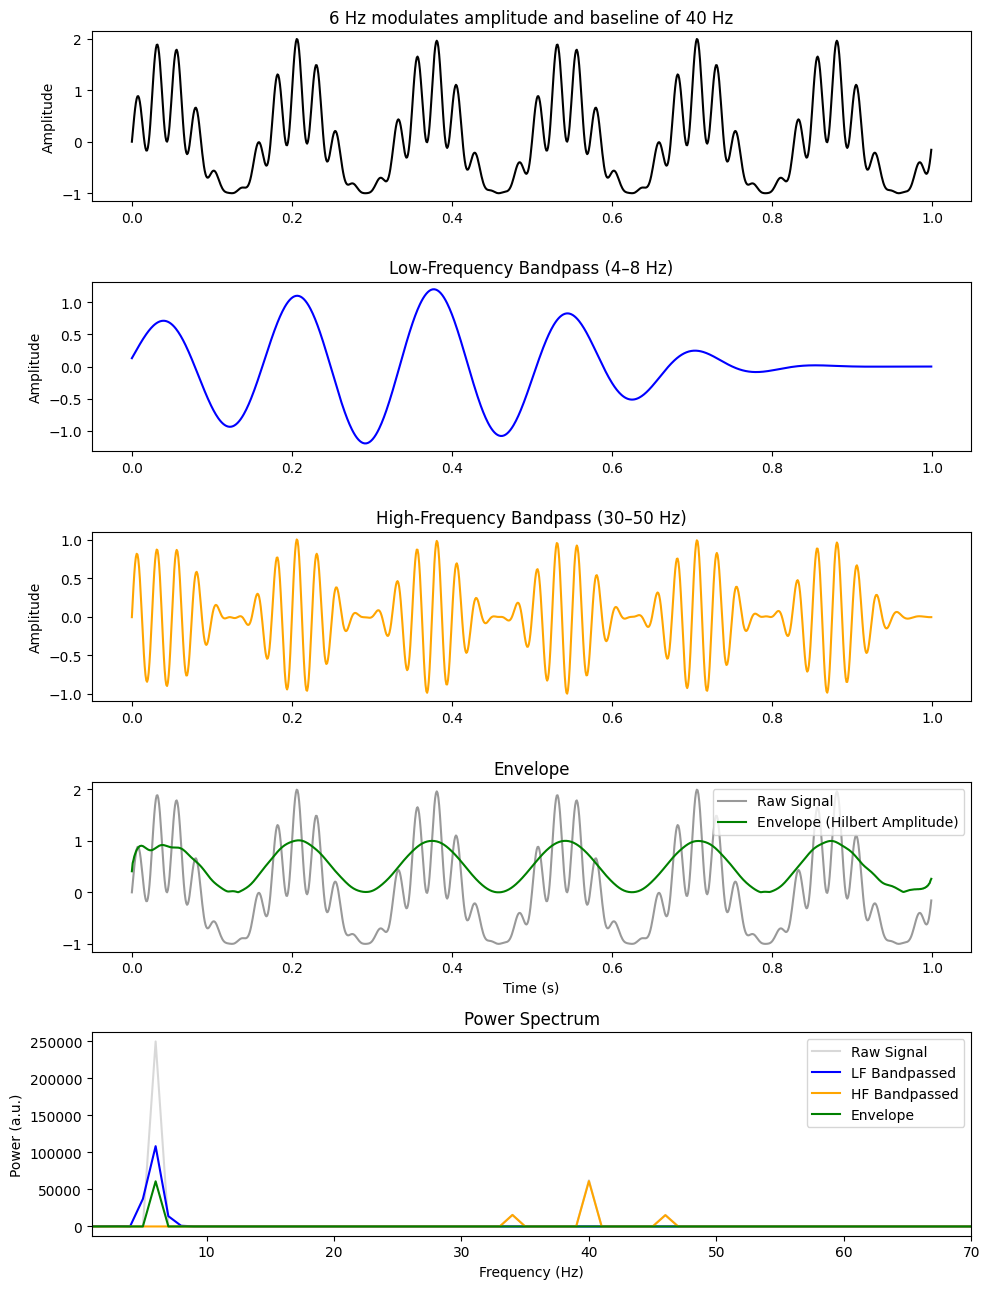

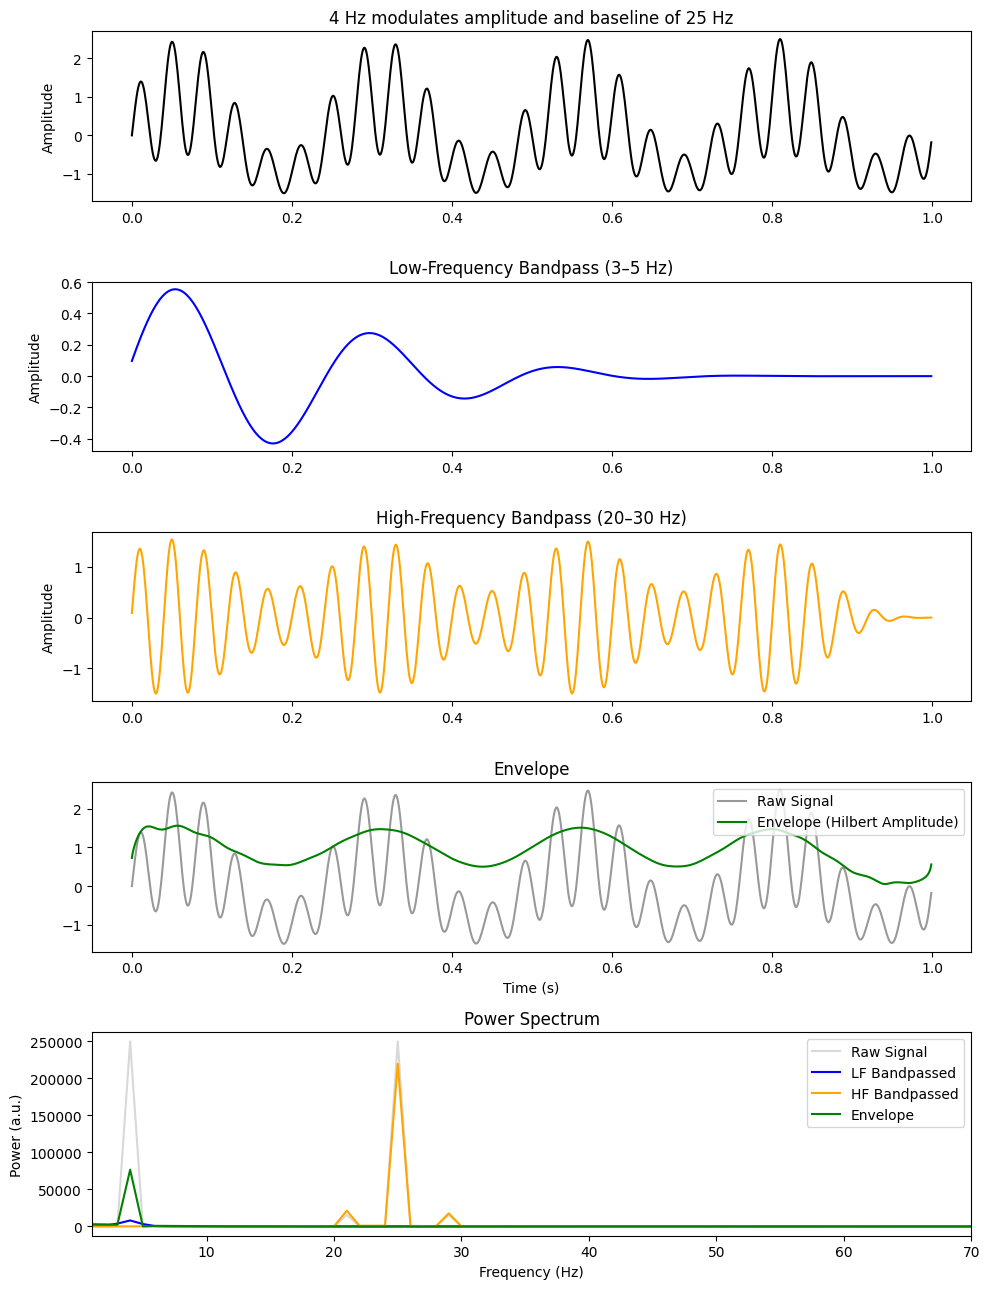

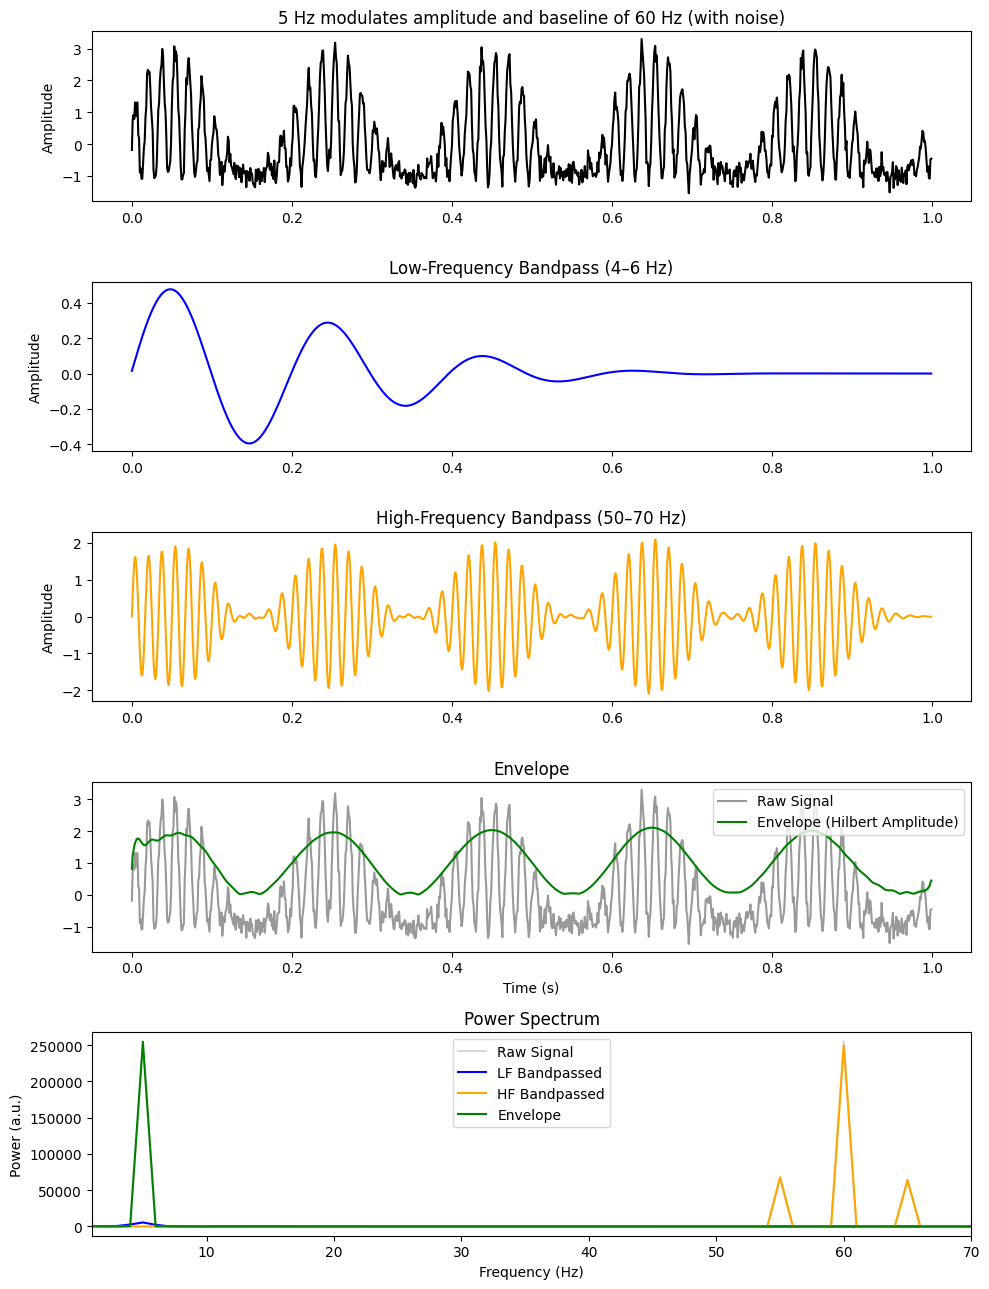

In [58]:
# Time vector and sampling rate
Fs = 1000  # Hz
t = np.arange(0, 1, 1/Fs)

# 6 Hz modulates amplitude AND centerline of 40 Hz
lf = np.sin(2 * np.pi * 6 * t)
hf = 0.5*np.sin(2 * np.pi * 40 * t)
signal1 = (1 + lf) * hf + lf
plot_modulation_decomposition(signal1, Fs, lf_band=(4, 8), hf_band=(30, 50), title="6 Hz modulates amplitude and baseline of 40 Hz")

# 4 Hz modulates amplitude and baseline of 25 Hz
lf = np.sin(2 * np.pi * 4 * t)
hf = np.sin(2 * np.pi * 25 * t)
signal4 = (1 + 0.5 * lf) * hf + lf
plot_modulation_decomposition(signal4, Fs, lf_band=(3, 5), hf_band=(20, 30), title="4 Hz modulates amplitude and baseline of 25 Hz")

# 5 Hz modulates amplitude and baseline of 60 Hz with noise
lf = np.sin(2 * np.pi * 5 * t)
hf = np.sin(2 * np.pi * 60 * t)
noise = 0.2 * np.random.randn(len(t))
signal5 = (1 + lf) * hf + lf + noise
plot_modulation_decomposition(signal5, Fs, lf_band=(4, 6), hf_band=(50, 70), title="5 Hz modulates amplitude and baseline of 60 Hz (with noise)")

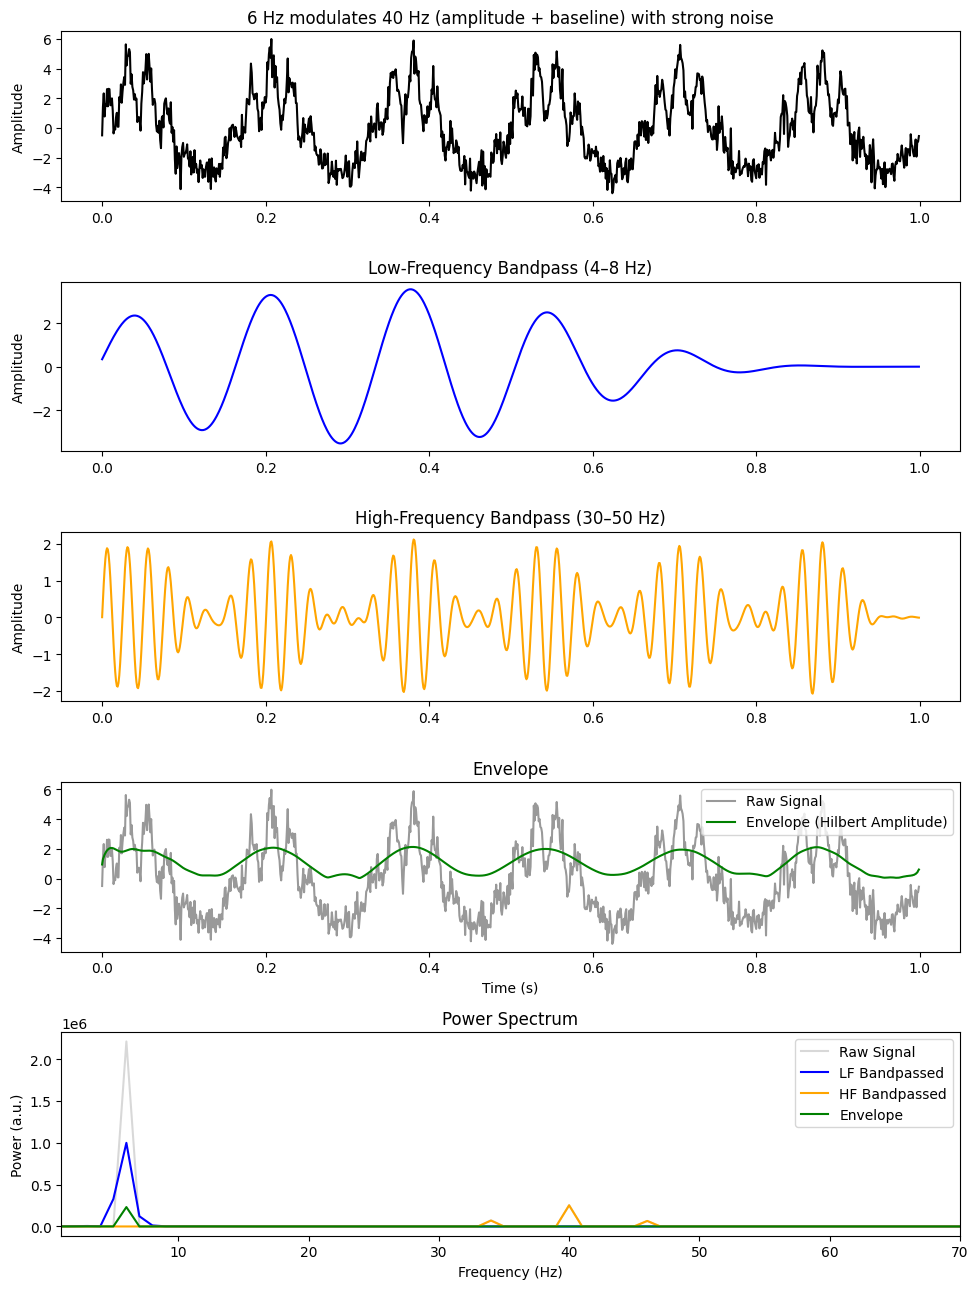

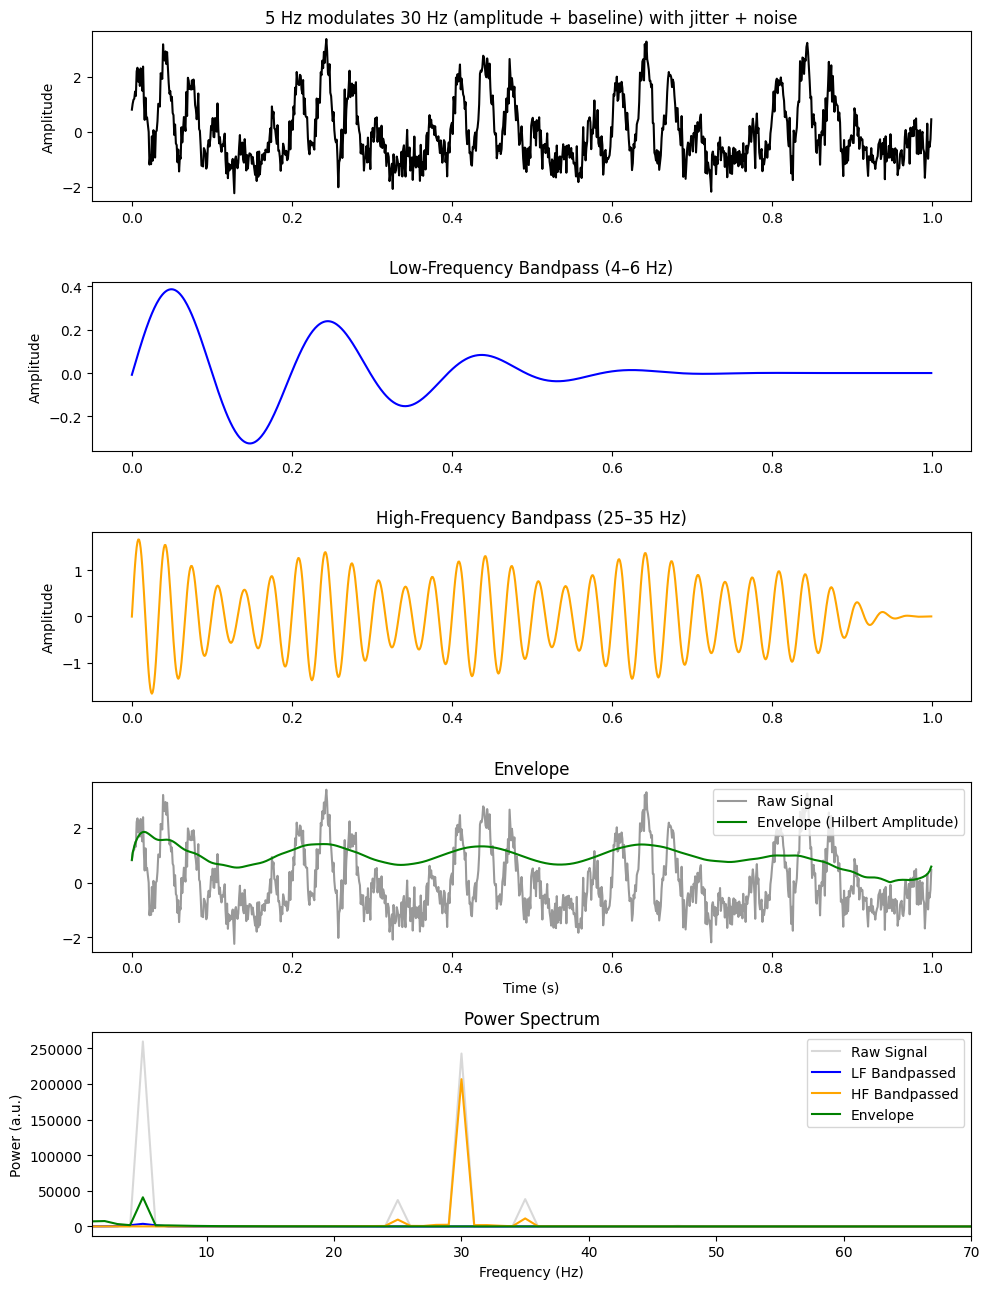

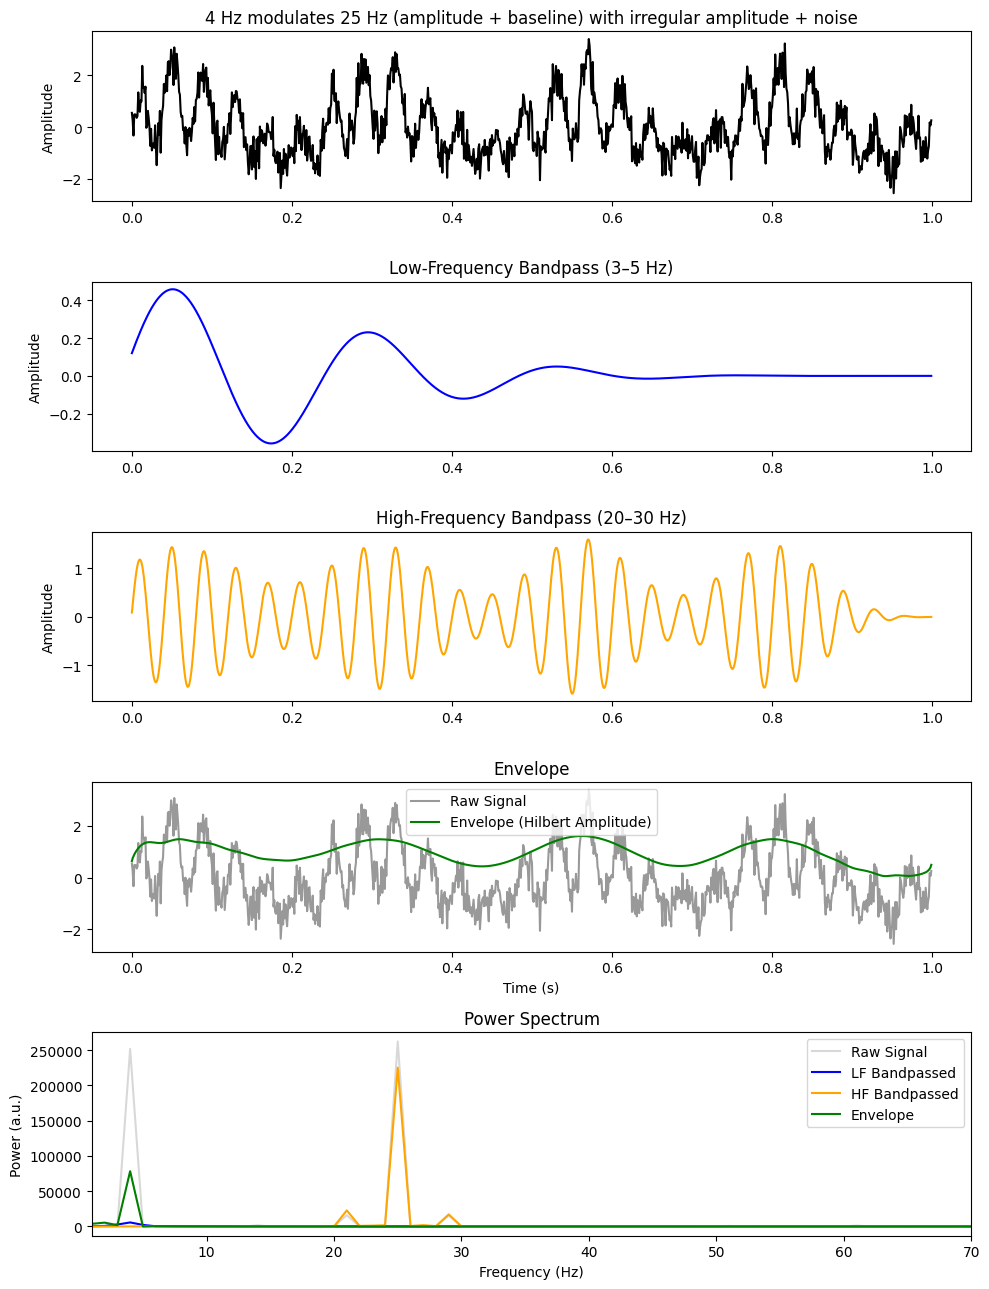

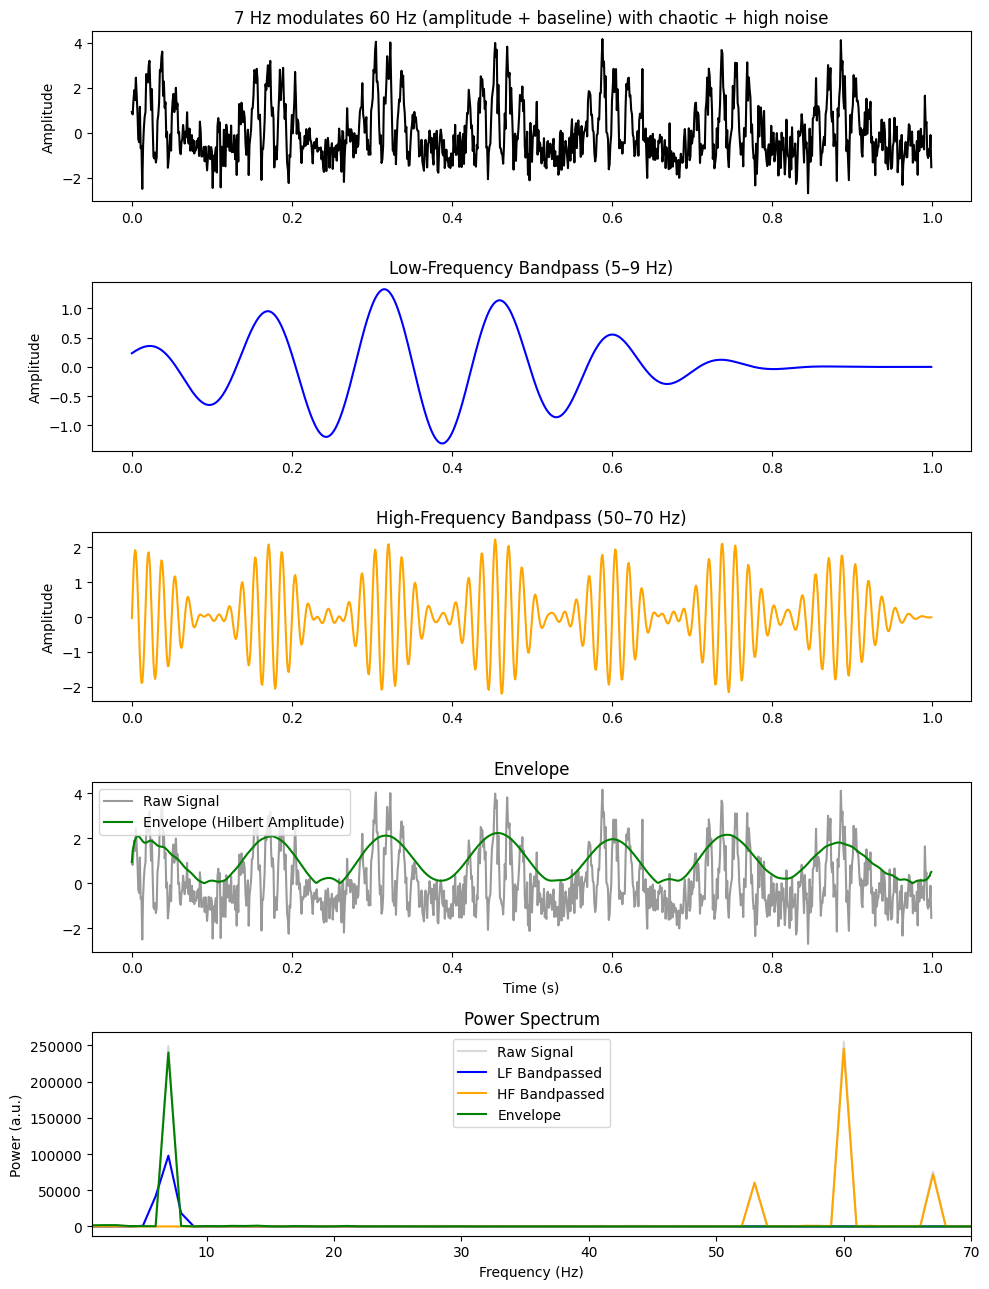

In [60]:
# Time and sampling
Fs = 1000
t = np.arange(0, 1, 1/Fs)

# Strong noise, 6 Hz modulating 40 Hz
lf = np.sin(2 * np.pi * 6 * t)
hf = np.sin(2 * np.pi * 40 * t)
noise = 0.6 * np.random.randn(len(t))
signal1 = (1 + lf) * hf + 3*lf + noise
plot_modulation_decomposition(signal1, Fs, lf_band=(4, 8), hf_band=(30, 50), title="6 Hz modulates 40 Hz (amplitude + baseline) with strong noise")

# Phase jittered 5 Hz modulator + 30 Hz carrier, noisy
lf_phase_jitter = np.sin(2 * np.pi * 5 * t + np.random.uniform(-0.5, 0.5))
hf = np.sin(2 * np.pi * 30 * t)
noise = 0.4 * np.random.randn(len(t))
signal2 = (1 + 0.8 * lf_phase_jitter) * hf + lf_phase_jitter + noise
plot_modulation_decomposition(signal2, Fs, lf_band=(4, 6), hf_band=(25, 35), title="5 Hz modulates 30 Hz (amplitude + baseline) with jitter + noise")

# Random amplitude scaling, 4 Hz × 25 Hz, irregular amplitude
lf = np.sin(2 * np.pi * 4 * t)
hf = np.sin(2 * np.pi * 25 * t)
amp_scale = 1 + 0.5 * lf + 0.3 * np.random.randn(len(t))
signal4 = amp_scale * hf + lf + 0.4 * np.random.randn(len(t))
plot_modulation_decomposition(signal4, Fs, lf_band=(3, 5), hf_band=(20, 30), title="4 Hz modulates 25 Hz (amplitude + baseline) with irregular amplitude + noise")

# Phase-jittered modulator, 7 Hz × 60 Hz, high noise
lf = np.sin(2 * np.pi * 7 * t + np.random.uniform(-1, 1))
hf = np.sin(2 * np.pi * 60 * t)
signal5 = (1 + lf) * hf + lf + 0.6 * np.random.randn(len(t))
plot_modulation_decomposition(signal5, Fs, lf_band=(5, 9), hf_band=(50, 70), title="7 Hz modulates 60 Hz (amplitude + baseline) with chaotic + high noise")